<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Hate Speech Detector

Today you are a machine learning engineer, a member of the Birdwatch at Twitter. 

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, a tweet contains hate speech if it has a racist or sexist sentiment associated with it. In other words, we need to classify racist or sexist tweets from other tweets.

A labelled dataset of 31,962 tweets (late 2017 to early 2018) is provided in the form of a compressed csv file with each line storing a tweet id, its label, and the tweet. Label '1' denotes the tweet is racist/sexist while label '0' denotes the tweet is not racist/sexist.

We will first approach the problem in a traditional approach: clean the raw text using simple regex (regular expression), extract features, build a naive Bayes models to classify tweets; then we build a deep learning model and explain our deep learning model with LIME.

## 📚 Learning Objectives

By the end of this lesson, you will be able to:

- Understand the basic concepts in natural language processing (NLP)
- Perform basic NLP tasks on text, e.g., tweets
- Build a naive Bayes classifier to detect hate speech 
- Build a bidirectional long short-term memory (BiLSTM) to detect hate speech
- Visualize embeddings with Tensorboard embedding projector
- Explain models with LIME

# Task I: Data Preprocessing


1. Install dependencies.

    Most modules are pre-installed in Colab, however, we need to update `gensim` to its recent version and install `lime`.

In [1]:
!pip install -U -q gensim==4.2.0 lime

gensim=a bunch of NLP functions : vectorization, classification, similarities
<br>lime = libray to explain predictions?

2. Connect Colab to your local Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3. Use `pandas.read_csv` to load the tweets in `tweets.csv.gz` and save the `pd.DataFrame` into `raw`. Make sure the path points to where the data is located in your Google Drive. 

In [3]:
# YOUR CODE HERE
import pandas as pd
raw = pd.read_csv('/content/drive/MyDrive/dog_dataset/tweets.csv.gz')

In [4]:
print(raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None


In [5]:
raw.head(2)

id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...

4. Sample 5 random tweets from the dataset for each label and display `label` and `tweet` columns. 
Hint: one option is to use `sample()` followed by `groupby`. 

In [6]:
# Colab includes an extension that renders pandas dataframes into interactive displays that can be filtered, sorted, and explored dynamically.
from google.colab import data_table
data_table.enable_dataframe_formatter() 

# YOUR CODE HERE
raw.groupby('label').sample(5)[['label','tweet']]

label                                              tweet
11609      0                     paying with a 5 yo.   #alaska 
6425       0  happy at work conference: right mindset leads ...
94         0  omg!!! loving this station!!! way to jam out a...
5678       0            many, many americans. that's right.    
28883      0  great golf today. @user   bihday witcom #livin...
332        1  @user you never answered me about your stateme...
7631       1  critics threaten boycotts of simon &amp; schus...
13288      1  @user and you will hear kurds are free and equ...
13990      1  @user #feminismiscancer #feminismisterrorism #...
3059       1     beware the "snowball effect" blackman! pa 2

5. The tweets are in English and all words should be already in lowercase. 
Now calculate the number of characters in each tweet and assign the values to a new column `len_tweet` in `raw`. 

In [7]:
# YOUR CODE HERE
raw['len_tweet'] = raw['tweet'].str.len()

In [8]:
raw.head(2)

id  label                                              tweet  len_tweet
0   1      0   @user when a father is dysfunctional and is s...        102
1   2      0  @user @user thanks for #lyft credit i can't us...        122

6. What are the summary statistics of `len_tweet` for each label? 
Hint: use `groupby` and `describe`. 

In [9]:
pd.set_option("display.precision", 1)

# YOUR CODE HERE
raw.groupby('label')['len_tweet'].describe()

count  mean   std   min   25%   50%    75%    max
label                                                     
0      29720.0  84.3  29.6  11.0  62.0  88.0  107.0  274.0
1       2242.0  90.2  27.4  12.0  69.0  96.0  111.0  152.0

Note we have an imbalanced dataset: the ratio of non-hate speech to hate speech is roughly 13:1. 

7. Clean the tweets. 

    We use `re` to perform basic text manipulations. 
    Specically, remove anonymized user handle, remove numbers and special characters except hashtags.

In [10]:
import re

8. Remove user handles from the text in `tweet`, or anything directly following the symbols `@`, and save the resulting tweets to a new column `tidy_tweet` in `raw`. 
    
    Hint: you can use `re.sub` on individual text and [`apply`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) a simple lambda function for the series `raw['tweet']`.

   CHATGPT:   using re.sub(r'@\w+', '', text) can remove any substring that starts with the "@" symbol and is followed by one or more word characters or digits from a given string. + represent one or more characters





In [11]:
# YOUR CODE HERE
# raw['tidy_tweet'] = raw['tweet'].str.replace(r'@([A-Za-z0-9_&$%^*_]+)', '', regex=True)  this should also works. not sure about special characters()
raw['tidy_tweet'] = raw['tweet'].str.replace(r'@\w+', '')
raw.sample(10, random_state=203)

<ipython-input-11-93f737f1a82b>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  raw['tidy_tweet'] = raw['tweet'].str.replace(r'@\w+', '')


id  label                                              tweet  \
790      791      1  @user and you keep telling that only aryans ar...   
21928  21929      0                           @user what makes you  ?    
25642  25643      0   â #nzd/usd extends rbnz-led rally, hits fre...   
20436  20437      0  i'm on a mission to ride all of the animals!  ...   
22552  22553      0  the color of a human skin matters a lot to the...   
20014  20015      0  #kimkardashian what do you think at this wife ...   
8796    8797      1  the latest the all in one news24 daily!  thank...   
24859  24860      0  #arbor   bull up: you will dominate your bull ...   
13195  13196      0  âð¼ï¸â¤ï¸ð love my @user suitcase. l...   
14679  14680      0  really love this picture of bride anna with he...   

       len_tweet                                         tidy_tweet  
790          109   and you keep telling that only aryans are all...  
21928         25                                 what makes you  ?   
25642        101   â #nzd/usd extends rbnz-led rally, hits fre...  
20436         91  i'm on a mission to ride all of the animals!  ...  
22552         88  the color of a human skin matters a lot to the...  
20014         52  #kimkardashian what do you think at this wife ...  
8796          77  the latest the all in one news24 daily!  thank...  
24859        109  #arbor   bull up: you will dominate your bull ...  
13195        104  âð¼ï¸â¤ï¸ð love my  suitcase. lookin...  
14679        105  really love this picture of bride anna with he...

9. Remove non-alphabetic characters yet keep symbols `#` from `tidy_tweet` and save the result in `tidy_tweet`. 
In other words, keep all 26 letters and `#`.

    Note: in some applications, punctuations, emojis, or whether the word is in all caps can be of use. 
    You shall decide whether to extract such features for the application and perform error analysis to gain insight. 

In [12]:
raw['tidy_tweet'] = raw['tidy_tweet'].apply(lambda x: re.sub('[^a-zA-Z#]', ' ',x)) # YOUR CODE HERE
raw.sample(5, random_state=203)

id  label                                              tweet  \
790      791      1  @user and you keep telling that only aryans ar...   
21928  21929      0                           @user what makes you  ?    
25642  25643      0   â #nzd/usd extends rbnz-led rally, hits fre...   
20436  20437      0  i'm on a mission to ride all of the animals!  ...   
22552  22553      0  the color of a human skin matters a lot to the...   

       len_tweet                                         tidy_tweet  
790          109   and you keep telling that only aryans are all...  
21928         25                                 what makes you      
25642        101       #nzd usd extends rbnz led rally  hits fre...  
20436         91  i m on a mission to ride all of the animals   ...  
22552         88  the color of a human skin matters a lot to the...

10. Remove words that is shorter than 4 characters from the processed tweets.

    For example, 
      
    `i m on a mission to ride all of the animals #teamchanlv #vegas #lasvegas #funtimes`
      
    will be reduced to 
      
    `mission ride animals #teamchanlv #vegas #lasvegas #funtimes`


In [13]:
# YOUR CODE HERE
raw['tidy_tweet'] = raw['tidy_tweet'].map(lambda x: ' '.join([mot for mot in x.split() if len(mot) > 3]))
# this also works with apply instead of map

raw.sample(5, random_state=203)

id  label                                              tweet  \
790      791      1  @user and you keep telling that only aryans ar...   
21928  21929      0                           @user what makes you  ?    
25642  25643      0   â #nzd/usd extends rbnz-led rally, hits fre...   
20436  20437      0  i'm on a mission to ride all of the animals!  ...   
22552  22553      0  the color of a human skin matters a lot to the...   

       len_tweet                                         tidy_tweet  
790          109  keep telling that only aryans allowed rape wom...  
21928         25                                         what makes  
25642        101  #nzd extends rbnz rally hits fresh year high n...  
20436         91  mission ride animals #teamchanlv #vegas #lasve...  
22552         88  color human skin matters system when comes jud...

11. Remove stopwords and perform text normalization. 
    
    We will use `stopwords` collection and `SnowballStemmer` in `nltk` for this task. Before doing so, we need to tokenize the tweets. 
    Tokens are individual terms or words, and tokenization is simply to split a string of text into tokens. 
    You can use [`str.split()`](https://docs.python.org/3/library/stdtypes.html#str.split) on individual text and [`apply`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) a simple lambda function for the series `raw['tidy_tweet']` and save the result into `tokenized_tweet`. 
    
    Check out some methods for the built-in type `str` [here](https://docs.python.org/3/library/stdtypes.html#string-methods).

In [14]:
tokenized_tweet = raw['tidy_tweet'].map(lambda x: x.split())# YOUR CODE HERE
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

12. Extract stop words and remove them from the tokens.

    Note: depending on the task / industry, it is highly recommended that one curate custom stop words. 

In [15]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
stop_words[0:10] # example of stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [17]:
len(stop_words) #how many stop words are there?

179

In [18]:
stopwords.words('french')[0:10]

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle']

In [19]:
len(stopwords.words('french'))

157

In [20]:
tokenized_tweet = tokenized_tweet.apply(lambda x: [i for i in x if not i in stop_words]) 
# tokenized_tweet = [word for word in tokenized_tweet if words not in stop_words] NADAV CODE
# YOUR CODE HERE

In [21]:
tokenized_tweet.head(5)
# with is gone --> works

0    [father, dysfunctional, selfish, drags, kids, ...
1    [thanks, #lyft, credit, cause, offer, wheelcha...
2                                    [bihday, majesty]
3                           [#model, love, take, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [22]:
assert any(word in tokenized_tweet for word in stop_words) == False

13. Create a new instance of a language specific [`SnowballStemmer`](https://www.nltk.org/api/nltk.stem.snowball.html), set the `language` to be "english"; see [how to](https://www.nltk.org/howto/stem.html). 

In [23]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english') # YOUR CODE HERE

In [24]:
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
tokenized_tweet.head()
#stem: racine - lem: equivalent word

0    [father, dysfunct, selfish, drag, kid, dysfunc...
1    [thank, #lyft, credit, caus, offer, wheelchair...
2                                    [bihday, majesti]
3                           [#model, love, take, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [25]:
stemmer.stem("running")

'run'

14. Lastly, let's stitch these tokens in `tokenized_tweet` back together and save them in `raw['tidy_tweet']`. 
Use [`str.join()`](https://docs.python.org/3/library/stdtypes.html#str.join) and `apply`.

In [26]:
raw['tidy_tweet'] = tokenized_tweet.map(lambda x: ' '.join(x)) # YOUR CODE HERE

In [27]:
raw.head(5)# comment est ce que l'index n'est pas perdu? le join se fait sur l'index

id  label                                              tweet  len_tweet  \
0   1      0   @user when a father is dysfunctional and is s...        102   
1   2      0  @user @user thanks for #lyft credit i can't us...        122   
2   3      0                                bihday your majesty         21   
3   4      0  #model   i love u take with u all the time in ...         86   
4   5      0             factsguide: society now    #motivation         39   

                                          tidy_tweet  
0     father dysfunct selfish drag kid dysfunct #run  
1  thank #lyft credit caus offer wheelchair van #...  
2                                     bihday majesti  
3                              #model love take time  
4                           factsguid societi #motiv

# Task 2. Wordcloud and Hashtag

In this task, we want to gain a general idea of what the common words were and how hashtags were used in tweets. 
We will create wordclouds and extract the top hashtags used in each label. 

1. Before doing so, out of caution of possible data leakage, split the `raw['tidy_tweet']` into training and test datasets in a stratified fashion, set the test size at .25 and random state as 42. WHY WOULD THERE BE LEAKAGE?
    
    Save the results into `X_train`, `X_test`, `y_train`, and `y_test`.

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    raw['tidy_tweet'], raw.label, 
    test_size=0.25, random_state=42, stratify=raw.label)

In [29]:
assert X_train.shape == y_train.shape == (23971, )
assert X_test.shape == y_test.shape == (7991,)

2. A word cloud is a cluster of words depicted in different sizes. 
The bigger the word appears, the more often it appears in the given text. 
It can offer an easy visual presentation to reveal the theme of a topic. 

    Function `plot_wordcloud` is provided to plot 50 most frequent words from the given text in the shape of twitter's logo. 
    You may need to replace the image path accordingly.

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_wordcloud(text:str) -> None:
    '''
    Plot a wordcloud of top 50 words from the input text
    masked by twitter logo
    '''
    mask = np.array(Image.open('/content/drive/My Drive/dog_dataset/twitter-mask.png')) # REPLACE w/ YOUR FILE PATH
    wordcloud = WordCloud( 
        background_color='white', 
        random_state=42,
        max_words=50, 
        max_font_size=80, 
        mask = mask).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

3. Visualize the wordcloud. 

    The function expects one long string. 
    Stitch all tidy tweets from training set and save the single string to `all_words`, then visualize the wordcloud for all the words.

In [31]:
all_words = ' '.join(raw['tidy_tweet']) # YOUR CODE HERE

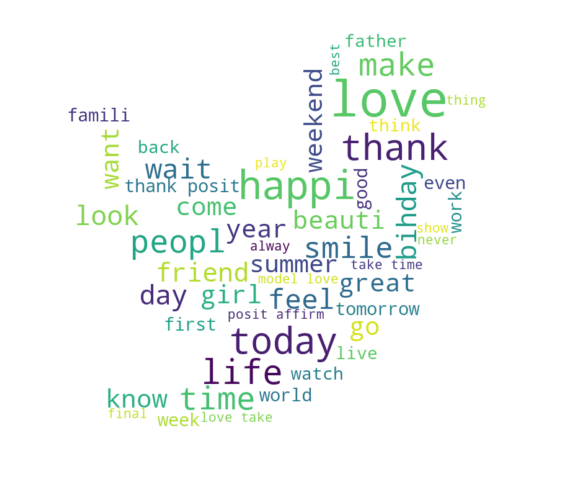

In [32]:
plot_wordcloud(all_words) #looks like a tweet

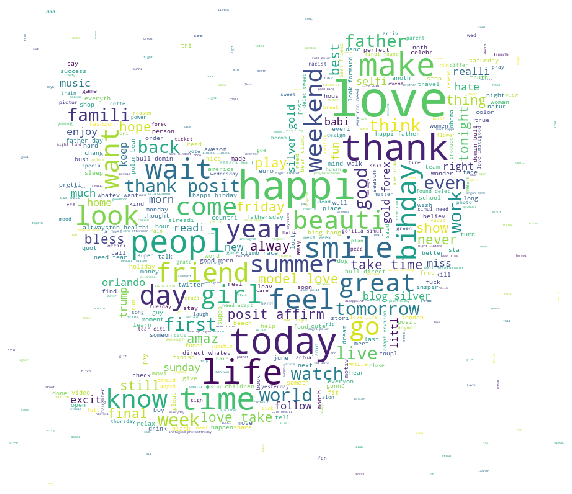

In [33]:
def plot_wordcloud2(text:str) -> None:  # change number of words to show
    '''
    Plot a wordcloud of top 50 words from the input text
    masked by twitter logo
    '''
    mask = np.array(Image.open('/content/drive/My Drive/dog_dataset/twitter-mask.png')) # REPLACE w/ YOUR FILE PATH
    wordcloud = WordCloud( 
        background_color='white', 
        random_state=42,
        max_words=500, 
        max_font_size=80, 
        mask = mask).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="nearest")
    plt.axis("off")
    plt.show()


plot_wordcloud2(all_words)

4. Visualize the wordcloud just for the text from the tweets identified as hate speech. 

    Similarly, you need to stitch all the tidy tweets in training set that were identified as hate speech. 
    Save the long string to `negative_words`.

In [34]:
# YOUR CODE HERE
mask = (raw['label']==1)
negative_words =' '.join(raw[mask]['tidy_tweet'])

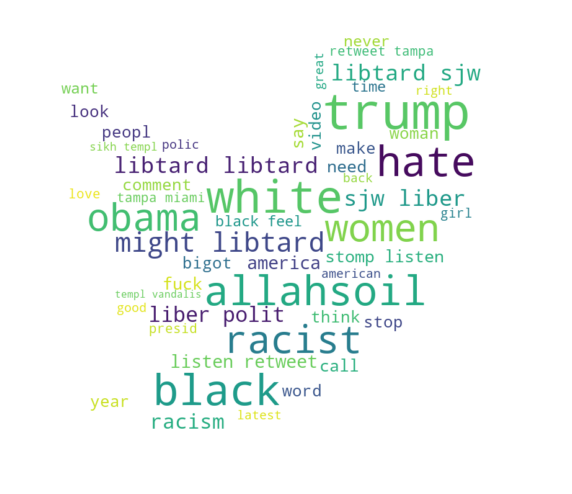

In [35]:
plot_wordcloud(negative_words)

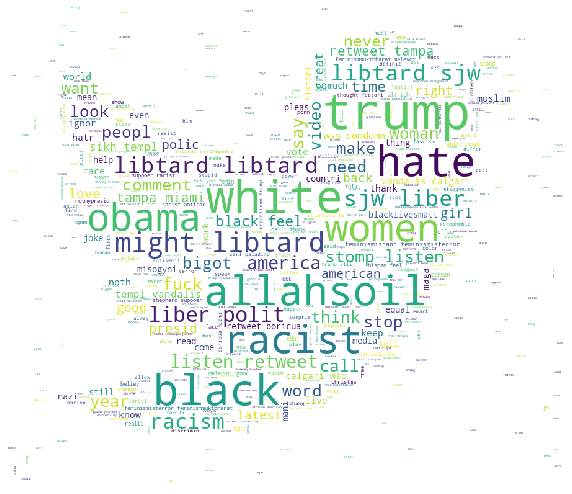

In [36]:
plot_wordcloud2(negative_words)

In [37]:
print("number of words: ",len(all_words)," number of negative words: ",len(negative_words))

number of words:  1518299  number of negative words:  114413


In [38]:
negative_words[1000:2000] #Negative words = part of negative speech

'esmatt #draintheswamp #ferguson horribl made cring die light villag green town #antisemit #hocoschool #columbiamd #hocomd never answer statement #nazi #hatr #bigotri found might libtard #libtard #sjw #liber #polit trump chair make racist remark michell obama #fyi #tcot say otherwis young girl confin kitchen void mean beyond cheap public #topoli block troll promis #blacklivesmatt nonsens rant boo nazi studi american race law inspir #ushistori #eugen #biher absolut origin hate #bigotri #altright hatr african american #potus #theresist offic viral arrest video rude racist chief #crime #offic discuss republican thing critiqu ignor consequ #black feel like stomp #retweet #tampa #miami #allahsoil familiar becom difficult stereotyp anti racist codeword antiwhit asia asian africa african white countri everyon #prais #cleveland polic #rnc polic consent decre #white #tamirric #rip prevent #bigot girl world sexi matur housewif like #blacklivesmatt slogan talk #feminismiscanc #feminismisterror #f

5. Hashtag is a feature for tweets and we would like to inspect if hashtags provide information for our classification task. 

    Function `hashtag_extract` is provided to extract hastags from an iterable (list or series) and return the hashtags in a list. 

In [39]:
def hashtag_extract(x) -> list:  #WHY PUTTING ->? ISNT THE INITIALISATION DOING IT
    """
    extract hastags from an iterable (list or series) and 
    return the hashtags in a list.
    """
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

6. Extract hashtags from non-hate speech tweets.

In [40]:
# YOUR CODE HERE
mask0 = (raw['label']==0)
HT_regular =hashtag_extract(raw[mask0]['tidy_tweet'])

In [41]:
assert type(HT_regular) == list
assert type(HT_regular[0]) == list # nested list

7. Now extract hashtags from hate speech tweets.

In [42]:
HT_negative = hashtag_extract(raw[mask]['tidy_tweet'])# YOUR CODE HERE

In [43]:
HT_negative[0:5]

[['cnn', 'michigan', 'tcot'],
 ['australia',
  'opkillingbay',
  'seashepherd',
  'helpcovedolphin',
  'thecov',
  'helpcovedolphin'],
 [],
 [],
 ['neverump', 'xenophobia']]

In [44]:
HT_regular[0:5] # why is one on a line and the other in column?

[['run'], ['lyft', 'disapoint', 'getthank'], [], ['model'], ['motiv']]

8. Both `HT_regular` and `HT_negative` are nested lists, so use the following trick to unnest both lists.

In [45]:
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

In [46]:
HT_negative[0:5]

['cnn', 'michigan', 'tcot', 'australia', 'opkillingbay']

In [47]:
HT_regular[0:5]

['run', 'lyft', 'disapoint', 'getthank', 'model']

In [48]:
assert type(HT_regular) == type(HT_negative) == list
assert type(HT_regular[0]) == type(HT_negative[0]) == str

In [49]:
print("nombre de tag negatifs: ",len(HT_negative)," tag positifs: ",len(HT_regular))

nombre de tag negatifs:  4616  tag positifs:  68425


9. Complete the function `top_hashtags` below to take a list of hashtags and return the top `n` hashtag keyword and its frequncy. 

In [50]:
from typing import List, Tuple
from collections import Counter
def top_hashtags(hashtags:List[str], n=10) -> List[Tuple[str, int]]:
    ''' Function to return the top n hashtags '''
    mydict = Counter(hashtags)
    return mydict.most_common(n) 
    # YOUR CODE HERE

In [51]:
{k: Counter(HT_regular)[k] for k in list(Counter(HT_regular))[:5]} # CHECKING A DICTIONARY


{'run': 72, 'lyft': 2, 'disapoint': 1, 'getthank': 2, 'model': 375}

In [52]:
Counter(HT_regular).most_common(10)

[('love', 1654),
 ('posit', 917),
 ('smile', 676),
 ('healthi', 573),
 ('thank', 534),
 ('fun', 463),
 ('life', 425),
 ('affirm', 423),
 ('summer', 390),
 ('model', 375)]

1. Apply the function to the hashtag lists from the non-hate speech tweets and the hate speech tweets.

In [53]:
top_hashtags(HT_regular)# YOUR CODE HERE

[('love', 1654),
 ('posit', 917),
 ('smile', 676),
 ('healthi', 573),
 ('thank', 534),
 ('fun', 463),
 ('life', 425),
 ('affirm', 423),
 ('summer', 390),
 ('model', 375)]

In [54]:
top_hashtags(HT_negative)# YOUR CODE HERE

[('trump', 136),
 ('polit', 95),
 ('allahsoil', 92),
 ('liber', 81),
 ('libtard', 77),
 ('sjw', 74),
 ('retweet', 63),
 ('black', 46),
 ('miami', 46),
 ('hate', 37)]

10. DISCUSS: are these hashtags making sense? should we include them as features or should we strip the # before tokenizing (that is, treat "#love" the same as "love")? why and why not?
          <br>

```
# This is formatted as code
```

<br>The hashtags like "love" and "posit" are in the regular classification. It could be that it is the reverse of the negative tags not so much the neutral/other tags. sjw (social justice warrior) is in the negative, so it also shows how the overall population of twittos are feeling about it. Miami is also negative. Maybe it is a temporary negative feeling as there is no reason a town would be negative overall.<br><br>
As far as removing them to interpret a sentence, hashtags represent intended intentions. They are more important than the rest of the text. We could remove them if we replace them by a number equal to the total number of words in the tweet so a larger weight while counting the words. For example "#love #fun  great marc yesterday beach" morphed to "love love love love fun fun fun fun great marc yesterday beach" <br><br>
Overall it is not because a tweet is labeled hate that all the words in the tweet are insults. It is more that the topic word is considered negative at the time

# Task 3. Features

Note that almost all the machine learning related Python modules expect numerical presentation of data; thus we need to transform our text first.
We will experiment with bag of words, tf-idf, and word2vec.  

1. Convert the collection of text documents to a matrix of token counts.

    Check the [official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). 
    
    Create an instance of `CountVectorizer` named `bow_vectorizer`, set `max_features` to be `MAX_FEATURES`.
    Learn the vocabulary dictionary and return document-term matrix and save it to `bow_train`. Use `.fit_transform`. 

### bag of words / count vectorizer count the number of words in the tweet
### tfidf count the importance of the words by tweet
### word to vec create a matrix saying if the word is in the tweet
## the line of the matrix is a tweet / what is the name of the column?

In [55]:
''' DOCUMENTATION CE TRUC DONNE LE  NOMBRE D'UNE LISTE DE 1000 MOTS DANS UN TWEET
>>> from sklearn.feature_extraction.text import CountVectorizer
>>> corpus = [
...     'This is the first document.',
...     'This document is the second document.',
...     'And this is the third one.',
...     'Is this the first document?',
... ]
>>> vectorizer = CountVectorizer()
>>> X = vectorizer.fit_transform(corpus)
>>> vectorizer.get_feature_names_out()
array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], ...)
>>> print(X.toarray())
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
>>> vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
>>> X2 = vectorizer2.fit_transform(corpus)
>>> vectorizer2.get_feature_names_out()
array(['and this', 'document is', 'first document', 'is the', 'is this',
       'second document', 'the first', 'the second', 'the third', 'third one',
       'this document', 'this is', 'this the'], ...)
 >>> print(X2.toarray())
 [[0 0 1 1 0 0 1 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 1 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 1 1 0 1 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 1]]

'''

" DOCUMENTATION CE TRUC DONNE LE  NOMBRE D'UNE LISTE DE 1000 MOTS DANS UN TWEET\nfrom sklearn.feature_extraction.text import CountVectorizer\ncorpus = [\n    'This is the first document.',\n    'This document is the second document.',\n    'And this is the third one.',\n    'Is this the first document?',\n]\nvectorizer = CountVectorizer()\nX = vectorizer.fit_transform(corpus)\nvectorizer.get_feature_names_out()\narray(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',\n       'this'], ...)\nprint(X.toarray())\n[[0 1 1 1 0 0 1 0 1]\n [0 2 0 1 0 1 1 0 1]\n [1 0 0 1 1 0 1 1 1]\n [0 1 1 1 0 0 1 0 1]]\nvectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))\nX2 = vectorizer2.fit_transform(corpus)\nvectorizer2.get_feature_names_out()\narray(['and this', 'document is', 'first document', 'is the', 'is this',\n       'second document', 'the first', 'the second', 'the third', 'third one',\n       'this document', 'this is', 'this the'], ...)\n >>> print(X2.toarray())\

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
MAX_FEATURES = 1000

bow_vectorizer = CountVectorizer(max_features=MAX_FEATURES)# Just a word by word - no pairsYOUR CODE HERE
bow_train = bow_vectorizer.fit_transform(X_train) # YOUR CODE HERE

In [57]:
assert bow_train.shape == (X_train.shape[0], MAX_FEATURES)

In [58]:
bow_train

<23971x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 96131 stored elements in Compressed Sparse Row format>

In [59]:
X_train.shape # 23971 is the number of tweets in the training datasets and there are 1000 columns = keywords

(23971,)

In [60]:
bow_vectorizer

CountVectorizer(max_features=1000)

In [61]:
X_train.head()

1036     like spread peanut butter white bread #littlewond
2380     watch made america simpson interest went still go
31605           franci underwood seen leav marseill #nojok
23437         #enjoy #music #today #free #app #free #music
2669     #juic experi #notsobad #healthyliv #eatclean #...
Name: tidy_tweet, dtype: object

In [62]:
cols = bow_vectorizer.get_feature_names_out()
for tweet_vector in bow_train.toarray()[:5]:
  print("Reduced tweet: ", " ".join([cols[col_idx] for col_idx, keep in enumerate(tweet_vector) if keep]))

Reduced tweet:  like white
Reduced tweet:  america go interest made still watch went
Reduced tweet:  leav seen
Reduced tweet:  enjoy free music today
Reduced tweet:  cook experi fit yummi


In [63]:
cols[0:12]

array(['abl', 'absolut', 'accept', 'account', 'act', 'action', 'activ',
       'actor', 'actual', 'adapt', 'adult', 'adventur'], dtype=object)

2. Print the first three rows from `bow_train`. Hint: `.toarray()`.

In [64]:
print(bow_train[0:3,:].shape)
bow_train[0:3,:].toarray()

# YOUR CODE HERE

(3, 1000)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [65]:
from scipy.sparse.csr import csr_matrix
assert type(bow_train) == csr_matrix

3. Similarly, convert the collection of text documents to a matrix of TF-IDF features.
    
    Create an instance of [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) named `tfidf_vectorizer`, set `max_features` to be `MAX_FEATURES`.

    Learn the vocabulary and idf, return document-term matrix and save it to `tfidf_train`. 

In [66]:
'''
TF = TERM FREQUENCY: 
IDF = Inverse document frequency: 
'This is the first document.'  --> this .2 / is .2 / the .2 /first .2 /document .2
'This document is the second document.', --> this 1/6 / is 1/6 / the 1/6 / second 1/6 /document 2/6

IDF : log(number of document/document that have the term) this:log(2/2)=0/is:log(2/2)/the log(2/2)/first:log(2/1)=.3/document:log2/2/second:log(2/1)
'''

"\nTF = TERM FREQUENCY: \nIDF = Inverse document frequency: \n'This is the first document.'  --> this .2 / is .2 / the .2 /first .2 /document .2\n'This document is the second document.', --> this 1/6 / is 1/6 / the 1/6 / second 1/6 /document 2/6\n\nIDF : log(number of document/document that have the term) this:log(2/2)=0/is:log(2/2)/the log(2/2)/first:log(2/1)=.3/document:log2/2/second:log(2/1)\n"

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [68]:
tfidf_vectorizer = TfidfVectorizer(max_features = MAX_FEATURES, stop_words = 'english')  # YOUR CODE HERE
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [69]:
assert type(tfidf_train) == csr_matrix
assert tfidf_train.shape == bow_train.shape == (X_train.shape[0], MAX_FEATURES)

In [70]:
tfidf_train[0:10,:].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
tfidf_train

<23971x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 89478 stored elements in Compressed Sparse Row format>

In [72]:
89478/23971/1000 #matrix is 4% filled

0.003732760418839431

4. Extract word embeddings using Word2Vec. 
We will use [`gensim`](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) for this task. 
    
    The Word2Vec model takes either a list of lists of tokens or an iterable that streams the sentences directly from disk/network. 
    Here, we tokenize the tidy tweets in `X_train` and save the list (`pd.series`) of lists of tokens to `tokenized_tweet`. 

In [73]:
X_train

1036     like spread peanut butter white bread #littlewond
2380     watch made america simpson interest went still go
31605           franci underwood seen leav marseill #nojok
23437         #enjoy #music #today #free #app #free #music
2669     #juic experi #notsobad #healthyliv #eatclean #...
                               ...                        
15438    scratch last tweet sorri someon borrow box wit...
29797    special moment everyth around #famili #familia...
15613                         kudo compliant #itaxnirahisi
1955     #streetautopia attack bull game realli think h...
9371                                                      
Name: tidy_tweet, Length: 23971, dtype: object

In [74]:
laliste = ([tweet.split(' ') for tweet in X_train])
tokenized_tweet = pd.Series(laliste)
# YOUR CODE HERE

In [75]:
tokenized_tweet

0        [like, spread, peanut, butter, white, bread, #...
1        [watch, made, america, simpson, interest, went...
2        [franci, underwood, seen, leav, marseill, #nojok]
3        [#enjoy, #music, #today, #free, #app, #free, #...
4        [#juic, experi, #notsobad, #healthyliv, #eatcl...
                               ...                        
23966    [scratch, last, tweet, sorri, someon, borrow, ...
23967    [special, moment, everyth, around, #famili, #f...
23968                     [kudo, compliant, #itaxnirahisi]
23969    [#streetautopia, attack, bull, game, realli, t...
23970                                                   []
Length: 23971, dtype: object

In [76]:
assert tokenized_tweet.shape == X_train.shape

In [77]:
tokenized_tweet.head()

0    [like, spread, peanut, butter, white, bread, #...
1    [watch, made, america, simpson, interest, went...
2    [franci, underwood, seen, leav, marseill, #nojok]
3    [#enjoy, #music, #today, #free, #app, #free, #...
4    [#juic, experi, #notsobad, #healthyliv, #eatcl...
dtype: object

5. Import `Word2Vec` from `gensim.models`; see [doc](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec). 

    Create a skip-gram `Word2Vec` instance named `w2v` that learns on the `tokenized_tweet`, with `vector_size` set at `MAX_FEATURES`, and other parameters are provided. 

In [78]:
from gensim.models import Word2Vec

In [79]:
w2v = Word2Vec(
        tokenized_tweet,# YOUR CODE HERE
        vector_size = MAX_FEATURES,# 1000 / YOUR CODE HERE
        window=5, min_count=2, sg = 1, 
        hs = 0, negative = 10,  workers= 2, 
        seed = 34)


Skip gram: I have the man is here  what is after? / what is before>?<BR>
BOW: I have the and is, what comes in between

In [80]:
w2v.corpus_count

23971

6. Train the skip-gram model, set the epochs at 20.<BR>
>>> from gensim.models import Word2Vec
>>> sentences = [["cat", "say", "meow"], ["dog", "say", "woof"]]
>>>
>>> model = Word2Vec(min_count=1)
>>> model.build_vocab(sentences)  # prepare the model vocabulary
>>> model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)  # train word vectors
(1, 30)

In [81]:
%%time
w2v.train(tokenized_tweet, total_examples=w2v.corpus_count, epochs=20)# YOUR CODE HERE

CPU times: user 2min 6s, sys: 246 ms, total: 2min 7s
Wall time: 1min 18s


(2738279, 3223400)

7. Let's see how the model performs. 
Specify a word and print out the 10 most similar words from the our tweets in the training set. 
Use [`most_similar`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar). 
Hint: print the type of `w2v` and `w2v.wv`.

In [82]:
w2v.wv.most_similar('door')# YOUR CODE HERE

[('peed', 0.8020204305648804),
 ('ckkosho', 0.6905469298362732),
 ('bistro', 0.640774130821228),
 ('#fleet', 0.6326006650924683),
 ('butter', 0.6301395297050476),
 ('#indypopcon', 0.62177574634552),
 ('flipsidepa', 0.618442714214325),
 ('cruis', 0.6163899898529053),
 ('#bargain', 0.6116224527359009),
 ('#folkmus', 0.5993965268135071)]

In [83]:
w2v.wv.most_similar('interest')

[('greenspan', 0.6889585852622986),
 ('skew', 0.6765385866165161),
 ('simpson', 0.6683934926986694),
 ('march', 0.6556376814842224),
 ('linkedin', 0.6372495889663696),
 ('violat', 0.6292685866355896),
 ('#bernieorbust', 0.6274780035018921),
 ('fewer', 0.6271276473999023),
 ('rate', 0.6251339912414551),
 ('crash', 0.6250808238983154)]

In [84]:
w2v.wv.most_similar('gilles')

KeyError: ignored

8. Discuss: how does w2v calculate the similarities? 

      it does cosinus of embedded vectors = . product 
    (a1,a2,a3,a4....,an)x(b1,b2,b3,b4,...bn) = (a1xb1,a2xb2,a3xb...,anxbn)<br>
    An embedding model might represent "cat" as a vector of numerical values, such as: [0.2, 0.8, -0.5, 1.3, -0.7, 0.4, -0.9, 0.2, 0.1, 0.6]

9. Discuss: do you think Word2Vec is supervised or unsupervised ML technique?

   It is unsupervised because the data has no labels. 

10. Engineer features. 

    For each tweet, we calculate the average of embeddings (function `word_vector`) and then apply it to every tidy tweet in `X_train` (use function `tokens_to_array`).
    Both functions are provided, inspect the code and save the features in `w2v_train`.

In [85]:
from gensim.models.keyedvectors import KeyedVectors

def word_vector(tokens:list, size:int, keyed_vec:KeyedVectors= w2v.wv):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += keyed_vec[word].reshape((1, size))
            count += 1
        except KeyError: 
            # handling the case where the token is not in vocabulary        
            continue
    if count != 0:
        vec /= count
    return vec

def tokens_to_array(tokens:list, size:int, keyed_vec:KeyedVectors= w2v.wv): # c'est quoi ce truc?
    array = np.zeros((len(tokens), size))
    for i in range(len(tokens)):
        array[i,:] = word_vector(tokens.iloc[i], size, keyed_vec=keyed_vec)
    return array

In [86]:
w2v

In [87]:
w2v.wv

In [88]:
w2v.wv['trump'][0:50]

array([-0.15937266,  0.1919009 , -0.11518893, -0.19131622, -0.11841231,
        0.02154473,  0.03036755,  0.1775691 , -0.18393567,  0.2382805 ,
       -0.404388  , -0.30106878,  0.27841744,  0.22566059, -0.30592522,
       -0.10805049,  0.18522657,  0.1959194 ,  0.08202547, -0.12755014,
       -0.17407945,  0.21204531, -0.08087651, -0.22759785,  0.34336922,
       -0.0910221 ,  0.44281575,  0.13065481, -0.08454617,  0.05628834,
       -0.3992184 ,  0.04013685,  0.1892024 , -0.24262   , -0.0420069 ,
       -0.24658442, -0.24614853,  0.08867681,  0.09440164,  0.13150908,
        0.0375063 , -0.35556078, -0.18854934,  0.19037119,  0.19614983,
        0.05860187, -0.30113736, -0.29859442, -0.02189154, -0.21695136],
      dtype=float32)

In [89]:
c=np.dot(w2v.wv['trump'],w2v.wv['door'])

In [90]:
a = np.sqrt(np.dot(w2v.wv['trump'],w2v.wv['trump']));b= np.sqrt(np.dot(w2v.wv['door'],w2v.wv['door']));

In [91]:
c/a/b

0.14259028

In [92]:
'''
In other words, the expression keyed_vec: KeyedVectors = w2v.wv is declaring that the variable keyed_vec is of type KeyedVectors, 
and it is assigned the same value as the wv attribute of the Word2Vec instance referred to by the w2v variable.
'''

'\nIn other words, the expression keyed_vec: KeyedVectors = w2v.wv is declaring that the variable keyed_vec is of type KeyedVectors, \nand it is assigned the same value as the wv attribute of the Word2Vec instance referred to by the w2v variable.\n'

In [93]:
# tokenized_tweet = token list of x_train
w2v_train = tokens_to_array(tokenized_tweet, MAX_FEATURES,)# YOUR CODE HERE

In [94]:
w2v_train

array([[-6.28982813e-02, -1.04167955e-01, -3.21264757e-02, ...,
         7.86889647e-03,  1.03073504e-02, -9.61533670e-04],
       [-2.49817568e-02, -1.13907294e-01, -4.77963787e-02, ...,
         2.52240677e-02,  5.73494092e-02,  1.96319734e-02],
       [-2.19045160e-02, -1.51718249e-01, -1.39133472e-01, ...,
         7.25803574e-02, -1.40360083e-01,  3.98343913e-02],
       ...,
       [ 3.16075816e-02, -4.11935697e-02, -4.15911383e-02, ...,
         1.89043904e-02,  6.65284631e-02, -1.66999381e-02],
       [ 9.86405992e-02, -1.80430813e-01, -1.04634825e-01, ...,
         6.41921585e-02,  6.41767623e-02, -1.31548850e-02],
       [ 7.78403541e-04,  6.58965320e-04,  6.61268714e-04, ...,
        -7.78804999e-04,  9.68253124e-04, -1.15775583e-04]])

In [95]:
w2v_train.shape

(23971, 1000)

In [96]:
assert w2v_train.shape == (X_train.shape[0], MAX_FEATURES) # single embedding is found in 

11. Prepare the test data before modeling for each approach:


  - extract features from `X_test` using the bag of words approach; use `bow_vectorizer`
  - extract features from `X_test` using the tf-idf approach; use `tfidf_vectorizer`
  - extract features from `X_test` using Word2Vec embeddings; you need to first tokenized the tidy tweets in `X_test`, then convert the tokens to array of shape `(X_test.shape[0], MAX_FEATURES)`.

In [97]:
bow_test = bow_vectorizer.transform(X_test) # YOUR CODE HERE
tfidf_test = tfidf_vectorizer.transform(X_test) # YOUR CODE HERE

tokenized_tweet_test = X_test.apply(lambda x: x.split())# YOUR CODE HERE
w2v_test = tokens_to_array(tokenized_tweet_test, size=MAX_FEATURES)# YOUR CODE HERE

In [98]:
assert bow_test.shape == tfidf_test.shape == w2v_test.shape == (X_test.shape[0], MAX_FEATURES)

# Task 4. Naive Bayes classifiers

In this task, you will build a [naive Bayes](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html) (here's another [ref](https://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn07-notes-nup.pdf)), classifiers to identify the hate speech tweets using different sets of features from the last task, and evaluate their performances. 

In the era of deep learning, naive Bayes is useful due to its simplicity and reasonable performance, especially if there is not much training data available. A common interview question is "Why is naive Bayes naive?". 

We will use multi-variate Bernoulli naive Bayes [`BernoulliNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html); try other flavors of [naive Bayes](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes) if time permits. Code is pretty straightforward. 

1. Import `BernoulliNB` for modeling and `classification_report` for reporting performance. 

In [99]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

2. Create an instance of  `BernoulliNB` named `BNBmodel`. 

    We can use it for all three feature sets.

In [100]:
# YOUR CODE HERE
BNBmodel = BernoulliNB()

3. Train the multi-variate Bernoulli naive Bayes using bag of words features and print the performance report.

In [101]:
# YOUR CODE HERE (train the model)
BNBmodel.fit(bow_train, y_train) # bow train is bag of words - y_train 0 or 1

BernoulliNB()

In [102]:
# YOUR CODE HERE (report)
bow_pred_test = BNBmodel.predict(bow_test)
print(classification_report(y_test, bow_pred_test))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      7430
           1       0.56      0.46      0.51       561

    accuracy                           0.94      7991
   macro avg       0.76      0.72      0.74      7991
weighted avg       0.93      0.94      0.93      7991



4. Similarly, train the model using tf-idf features and print the performance report. 

    Is the performance expected? Why or why not?

In [103]:
# YOUR CODE HERE
BNBmodel.fit(tfidf_train, y_train)

BernoulliNB()

In [104]:
# YOUR CODE HERE
tfidf_pred_test = BNBmodel.predict(tfidf_test)
print(classification_report(y_test, tfidf_pred_test))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      7430
           1       0.56      0.47      0.51       561

    accuracy                           0.94      7991
   macro avg       0.76      0.72      0.74      7991
weighted avg       0.93      0.94      0.93      7991



5. Finally, train the model using Word2Vec embeddings and report the performance. 

In [105]:
BNBmodel.fit(w2v_train, y_train)# YOUR CODE HERE
w2v_pred_test = BNBmodel.predict(w2v_test)
print(classification_report(y_test, w2v_pred_test))# YOUR CODE HERE

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7430
           1       0.29      0.82      0.43       561

    accuracy                           0.85      7991
   macro avg       0.64      0.83      0.67      7991
weighted avg       0.94      0.85      0.88      7991



In [107]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,w2v_pred_test)

array([[6317, 1113],
       [ 102,  459]])

6. Discuss the differences in performace using tf-idf vs skim-gram embeddings. 
<br>Word to vec appears to be worse than bag of word or tdidf

7. Examine a few tweets where the model(s) failed. 
What other features would you include in the next iteration?

    We looked at the 3 models: keep the 3 letters words (not the stopwords) sex in 15635 tweet is missing and change the classification
    Keep the emoji

In [108]:
misclassified_bow = np.where(np.array(y_test) != bow_pred_test)
misclassified_index = X_test.iloc[misclassified_bow].index
raw.iloc[misclassified_index].head()

id  label                                              tweet  \
31522  31523      0   @user it's sad!! our world is turning into a ...   
23135  23136      1  @user why is #obamalegacy only showing negativ...   
15634  15635      1  @user this guy look like his brother is @user ...   
10706  10707      0  so the @user tells all the other players there...   
25629  25630      1               you me too ððððð ð¹    

       len_tweet                                         tidy_tweet  
31522        126  world turn polit zoolog disast govern truli ev...  
23135        103  #obamalegaci show negat stuff confus #obama #p...  
15634        128  look like brother first wife found anoth document  
10706         89                     tell player might penalti sure  
25629         36

In [109]:
misclassified_tfidf = np.where(np.array(y_test) != tfidf_pred_test)
misclassified_index = X_test.iloc[misclassified_tfidf].index
raw.iloc[misclassified_index].head()

id  label                                              tweet  \
31522  31523      0   @user it's sad!! our world is turning into a ...   
23135  23136      1  @user why is #obamalegacy only showing negativ...   
15634  15635      1  @user this guy look like his brother is @user ...   
25629  25630      1               you me too ððððð ð¹    
5693    5694      0  maybe it's time for conservatives &amp; workin...   

       len_tweet                                         tidy_tweet  
31522        126  world turn polit zoolog disast govern truli ev...  
23135        103  #obamalegaci show negat stuff confus #obama #p...  
15634        128  look like brother first wife found anoth document  
25629         36                                                     
5693          88  mayb time conserv work class american realli t...

In [110]:
misclassified_w2v = np.where(np.array(y_test) != w2v_pred_test)
misclassified_index = X_test.iloc[misclassified_w2v].index
raw.iloc[misclassified_index].head()

id  label                                              tweet  \
21614  21615      0   @user @user  mate try addressing my argument ...   
31522  31523      0   @user it's sad!! our world is turning into a ...   
2100    2101      0  @user i cannot imagine being in the shoes of l...   
17364  17365      0  #rahul forcibly asking #punjabis to admit they...   
15634  15635      1  @user this guy look like his brother is @user ...   

       len_tweet                                         tidy_tweet  
21614         87   mate address argument rather #troll #staup #rude  
31522        126  world turn polit zoolog disast govern truli ev...  
2100         113  cannot imagin shoe local enforc first respond ...  
17364         68      #rahul forcibl ask #punjabi admit #drugaddict  
15634        128  look like brother first wife found anoth document

# Task 5. Bidirectional LSTM 

In this task, you will build a bidirectional LSTM (BiLSTM) model to detect tweets identified as hate speech, and visualize the embedding layer using Tensorboard projector. 

Why BiLSTM? LSTM, at its core, preserves information from inputs that has already passed through it using the hidden state. Unidirectional LSTM only preserves information of the past because the only inputs it has seen are from the past. BiLSTMs run inputs in both ways, one from past to future and one from future to past and show very good results as they can understand context better [ref](https://stackoverflow.com/questions/43035827/whats-the-difference-between-a-bidirectional-lstm-and-an-lstm).

1. Tokenizing and padding. 
    
    As LSTM expects every sentence to be of the same length, in addition to [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) with a given number of vocabulary `VOCAB_SIZE`, we need to [pad](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) shorter tweets with 0s until the length is `MAX_LEN` and truncate longer tweets to be exact `MAX_LEN` long. 
    
   Function `tokenize_pad_sequences` is provided except that you need to supply correct `num_words` and `filters`; do NOT filter `#`. 
   
   We feed the processed `tidy_tweet` to `tokenize_pad_sequences`, but one can perform the preprocessing steps in `Tokenizer` and apply it directly on the raw tweets.

In [111]:
VOCAB_SIZE = 25000  
MAX_LEN = 50

In [112]:
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer
# this does not work: from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences # this works

def tokenize_pad_sequences(text):
    '''
    tokenize the input text into sequences of integers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(
        num_words=VOCAB_SIZE,# YOUR CODE HERE
        filters= "!\"$%&()*+,-./:;<=>?@[\\]^{|}~\t\n",# remove chars YOUR CODE HERE
        lower=True, split=' ', oov_token='oov')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=MAX_LEN)

    return X, tokenizer

In [113]:
print('Before Tokenization & Padding \n', raw['tidy_tweet'][0])
X, tokenizer = tokenize_pad_sequences(raw['tidy_tweet'])
print('After Tokenization & Padding \n', X[0])
y = raw['label'].values

Before Tokenization & Padding 
 father dysfunct selfish drag kid dysfunct #run
After Tokenization & Padding 
 [  14 6492 2391 1685  211 6492  462    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


2. Let's split `X` into training and testing datasets, save 25% for testing. 
Then split training dataset into training and validation datasets, with 20% for validation. 
Set both `random_state` to be 42. 
Stratify both splits. 

In [114]:
X_train, X_test, y_train, y_test = train_test_split(
    # YOUR CODE HERE
    X, y, test_size=0.25, random_state=42, stratify=y
    )
X_train, X_val, y_train, y_val = train_test_split(
      X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    # YOUR CODE HERE
    )

In [115]:
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (19176, 50) (19176,)
Validation Set -> (4795, 50) (4795,)
Test Set -> (7991, 50) (7991,)


3. Now build a sequential model:

    - an embedding layer
    - a bidirectional LSTM with 32 units and set `return_sequences=True` in LSTM
    - a global average pooling operation for temporal data
    - a dropout layer with 20% rate
    - a dense layer of 32 units and set the activation function to be ReLu
    - a dense layer of 1 unit and set the proper activation function for classification

In [116]:
from keras.models import Sequential
# YOUR CODE HERE (layer imports)
from keras.layers import Embedding, Bidirectional, LSTM, GlobalAveragePooling1D, Dropout, Dense,Conv2D,MaxPooling2D
EMBEDDING_DIM = 16   
model = Sequential([
    # YOUR CODE HERE
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    Bidirectional(LSTM(32, return_sequences=True)),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [117]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          400000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         12544     
 l)                                                              
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 3

4. Compile the model. 

    Fill in a proper loss function and use adam as the optimizer. 
    For metrics, include precision and recall in the metrics, in addition to accuracy. 

In [118]:
from keras.metrics import Precision, Recall
model.compile(
    loss=keras.losses.BinaryCrossentropy(),# YOUR CODE HERE
    optimizer='adam', 
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]# YOUR CODE HERE]
    ) 

5. Train the model for 10 epochs on training dataset with a  validation set.

In [119]:
EPOCHS=10
BATCH_SIZE = 32
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),# YOUR CODE HERE
                    batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2)

Epoch 1/10
600/600 - 38s - loss: 0.2054 - accuracy: 0.9392 - precision: 0.6915 - recall: 0.2416 - val_loss: 0.1354 - val_accuracy: 0.9577 - val_precision: 0.7759 - val_recall: 0.5565 - 38s/epoch - 64ms/step
Epoch 2/10
600/600 - 31s - loss: 0.0856 - accuracy: 0.9735 - precision: 0.8513 - recall: 0.7532 - val_loss: 0.1198 - val_accuracy: 0.9606 - val_precision: 0.7928 - val_recall: 0.5923 - 31s/epoch - 52ms/step
Epoch 3/10
600/600 - 30s - loss: 0.0503 - accuracy: 0.9851 - precision: 0.9213 - recall: 0.8617 - val_loss: 0.1439 - val_accuracy: 0.9604 - val_precision: 0.7920 - val_recall: 0.5893 - 30s/epoch - 50ms/step
Epoch 4/10
600/600 - 31s - loss: 0.0355 - accuracy: 0.9904 - precision: 0.9518 - recall: 0.9093 - val_loss: 0.1718 - val_accuracy: 0.9485 - val_precision: 0.6240 - val_recall: 0.6667 - 31s/epoch - 51ms/step
Epoch 5/10
600/600 - 34s - loss: 0.0268 - accuracy: 0.9928 - precision: 0.9667 - recall: 0.9286 - val_loss: 0.2114 - val_accuracy: 0.9520 - val_precision: 0.6596 - val_reca

6. Function `plot_graphs` is provided below to visualize how the performance of model progresses as a function of epoch. 

    Visualize accuracy and loss. 

In [120]:
def plot_graphs(history, metric):
  fig, ax = plt.subplots()
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  ax.set_xticks(range(EPOCHS))
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

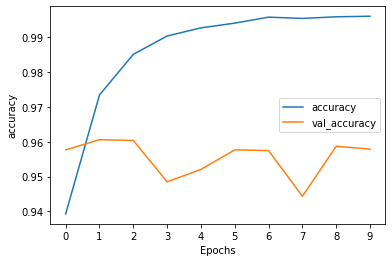

In [121]:
plot_graphs(history, 'accuracy')# YOUR CODE HERE

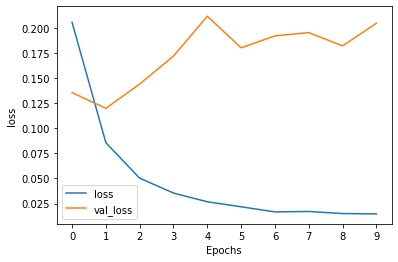

In [122]:
# YOUR CODE HERE
plot_graphs(history, 'loss')

7. The model starts to overfit after a couple of epochs. 
Consider using [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to stop training when a monitored metric has stopped improving. 

  What can we do to tame overfitting?

  regularization / mor training data / early stopping 

8. Print the classification report of the model on test dataset. 

In [123]:
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, np.round(model.predict(X_test))))
confusion_matrix(y_test,np.round(model.predict(X_test)))

250/250 [==============================] - 4s 12ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      7430
           1       0.70      0.60      0.64       561

    accuracy                           0.95      7991
   macro avg       0.83      0.79      0.81      7991
weighted avg       0.95      0.95      0.95      7991

250/250 [==============================] - 3s 12ms/step


array([[7283,  147],
       [ 225,  336]])

9. Discuss: how does the BiLSTM model improve the classification over naive Bayes? 

  The precision for the 1 is better than before. <br>Confusion matrix was: array ,   
            ([[6285, 1145],
              [  98,  463]])

In [124]:
# # NB using tf-idf
#               precision    recall  f1-score   support

#            0       0.96      0.97      0.97      7430
#            1       0.55      0.48      0.51       561

#     accuracy                           0.94      7991
#    macro avg       0.75      0.72      0.74      7991
# weighted avg       0.93      0.94      0.93      7991

# # NB using word2vec
#               precision    recall  f1-score   support

#            0       0.98      0.85      0.91      7430
#            1       0.29      0.82      0.43       561

#     accuracy                           0.85      7991
#    macro avg       0.64      0.83      0.67      7991
# weighted avg       0.94      0.85      0.88      7991

10. Visualize embeddings using [Embedding Projector](https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin) in Tensorboard. 
The setup for Tensorboard can be tricky, most of the code is provided. 

    TensorBoard reads tensors and metadata from the logs of your tensorflow projects. 
    The path to the log directory is specified with log_dir below. 
    
    In order to load the data into Tensorboard, we need to save a training checkpoint to that directory, along with metadata that allows for visualization of a specific layer of interest in the model.

    Load the TensorBoard notebook extension and import `projector` from `tensorboard.plugins`.

In [125]:
%load_ext tensorboard


In [126]:
from tensorboard.plugins import projector

11. Clear any logs from previous runs if any.

In [127]:
rm -rf /logs/  

12. Set up a logs directory, so Tensorboard knows where to look for data.

In [128]:
import os
log_dir='/logs/tweets-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [129]:
!pwd

/content


13. Save the first `VOCAB_SIZE` most frequent words in the vocabulary as `metadata.tsv`.

In [130]:
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  i = 0
  for label in tokenizer.word_index.keys():
    if label == 'oov':
      continue # skip oov
    f.write("{}\n".format(label))
    if i > VOCAB_SIZE:
      break
    i += 1

14. Save the weights we want to analyze as a variable. Note that the first value represents any unknown word, which is not in the metadata, here we will remove this value.

In [131]:
weights = tf.Variable(model.layers[0].get_weights()[0][1:]) # `embeddings` has a shape of (num_vocab, embedding_dim) 

In [132]:
weights

<tf.Variable 'Variable:0' shape=(24999, 16) dtype=float32, numpy=
array([[-0.05441592, -0.01958528, -0.02002177, ..., -0.04912097,
        -0.01186385,  0.06451681],
       [-0.07920238, -0.15150873, -0.09970753, ..., -0.14638622,
         0.10801373,  0.11863367],
       [-0.01317634, -0.05091694, -0.06263773, ..., -0.01266471,
         0.06096051,  0.00207767],
       ...,
       [-0.09134975, -0.05480463, -0.1146799 , ..., -0.05832238,
         0.12425968,  0.04149267],
       [-0.03300019, -0.07733785,  0.00665916, ..., -0.04637223,
         0.02971557,  0.03519234],
       [-0.11536727, -0.1307414 , -0.1157287 , ..., -0.06147895,
         0.06741837,  0.070274  ]], dtype=float32)>

15. Create a checkpoint from embedding, the filename and key are the name of the tensor.

In [133]:
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

'/logs/tweets-example/embedding.ckpt-1'

16. Set up config.

In [134]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()

17. The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.

In [135]:
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

18. Verify the following files exist under the current directory

In [136]:
ls /logs/tweets-example/

checkpoint                            metadata.tsv
embedding.ckpt-1.data-00000-of-00001  projector_config.pbtxt
embedding.ckpt-1.index


19. Now run Tensorboard against on log data we just saved. 

    You may need to run this cell **twice** to see the projector correctly. 
    Use Chrome for least friction.

In [138]:
%tensorboard --logdir /logs/tweets-example/

Reusing TensorBoard on port 6006 (pid 99980), started 0:00:13 ago. (Use '!kill 99980' to kill it.)

<IPython.core.display.Javascript object>

The TensorBoard Projector can be a great tool for interpreting and visualzing embedding. The dashboard allows users to search for specific terms, and highlights words that are adjacent to each other in the embedding (low-dimensional) space. Try a few word in the Search box and see if the embeddings make sense. 

# Task 6. Interpretation

Lastly let's try to understnad predictions by BiLSTM using a model agnostic approach -- [Local interpretable model-agnostic explanations (LIME)](https://christophm.github.io/interpretable-ml-book/lime.html)

1. Import `LimeTextExplainer` from the [`lime_text`](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_text) module in package [`lime`](https://github.com/marcotcr/lime)

In [139]:
from lime.lime_text import LimeTextExplainer

2. Create an instance of `LimeTextExplainer`, call it `explanier`. 

In [140]:
explainer = LimeTextExplainer(class_names=['no', 'yes'], random_state=2)

3. Method `explain_instance` expects the `classifier_fn` to be a function, we provide the function `predict_proba` as below. 

In [141]:
def predict_proba(arr):
    processed = tokenizer.texts_to_sequences(arr)
    processed = pad_sequences(processed, padding='post', maxlen=MAX_LEN)
    pred = model.predict(processed)
    r = []
    for i in pred:
        temp = i[0]
        r.append(np.array([1-temp,temp])) 
    return np.array(r)

4. Read about [`explain_instance`](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_text.LimeTextExplainer.explain_instance). 

    Create an instance named `exp` to explain the 16399th tidy tweet from the original dataset, i.e., `raw.tidy_tweet.iloc[16399]`. 

In [142]:
idx = 16399 
exp = explainer.explain_instance(
    # YOUR CODE HERE
    raw.tidy_tweet.iloc[idx],
    classifier_fn=predict_proba,
    num_features=6)
exp.show_in_notebook(text=raw.tidy_tweet.iloc[idx])

157/157 [==============================] - 3s 21ms/step


5. Pick another random tweet and generate explanations for the prediction.

In [143]:
# YOUR CODE HERE
idx = 1
exp = explainer.explain_instance(
    # YOUR CODE HERE
    raw.tidy_tweet.iloc[idx],
    classifier_fn=predict_proba,
    num_features=6)
exp.show_in_notebook(text=raw.tidy_tweet.iloc[idx])

157/157 [==============================] - 2s 12ms/step


6. Jot down your observations in explaining the model. 

This is a nice interpretation. The color orange is for yes and blue for no
There are different shades of colors

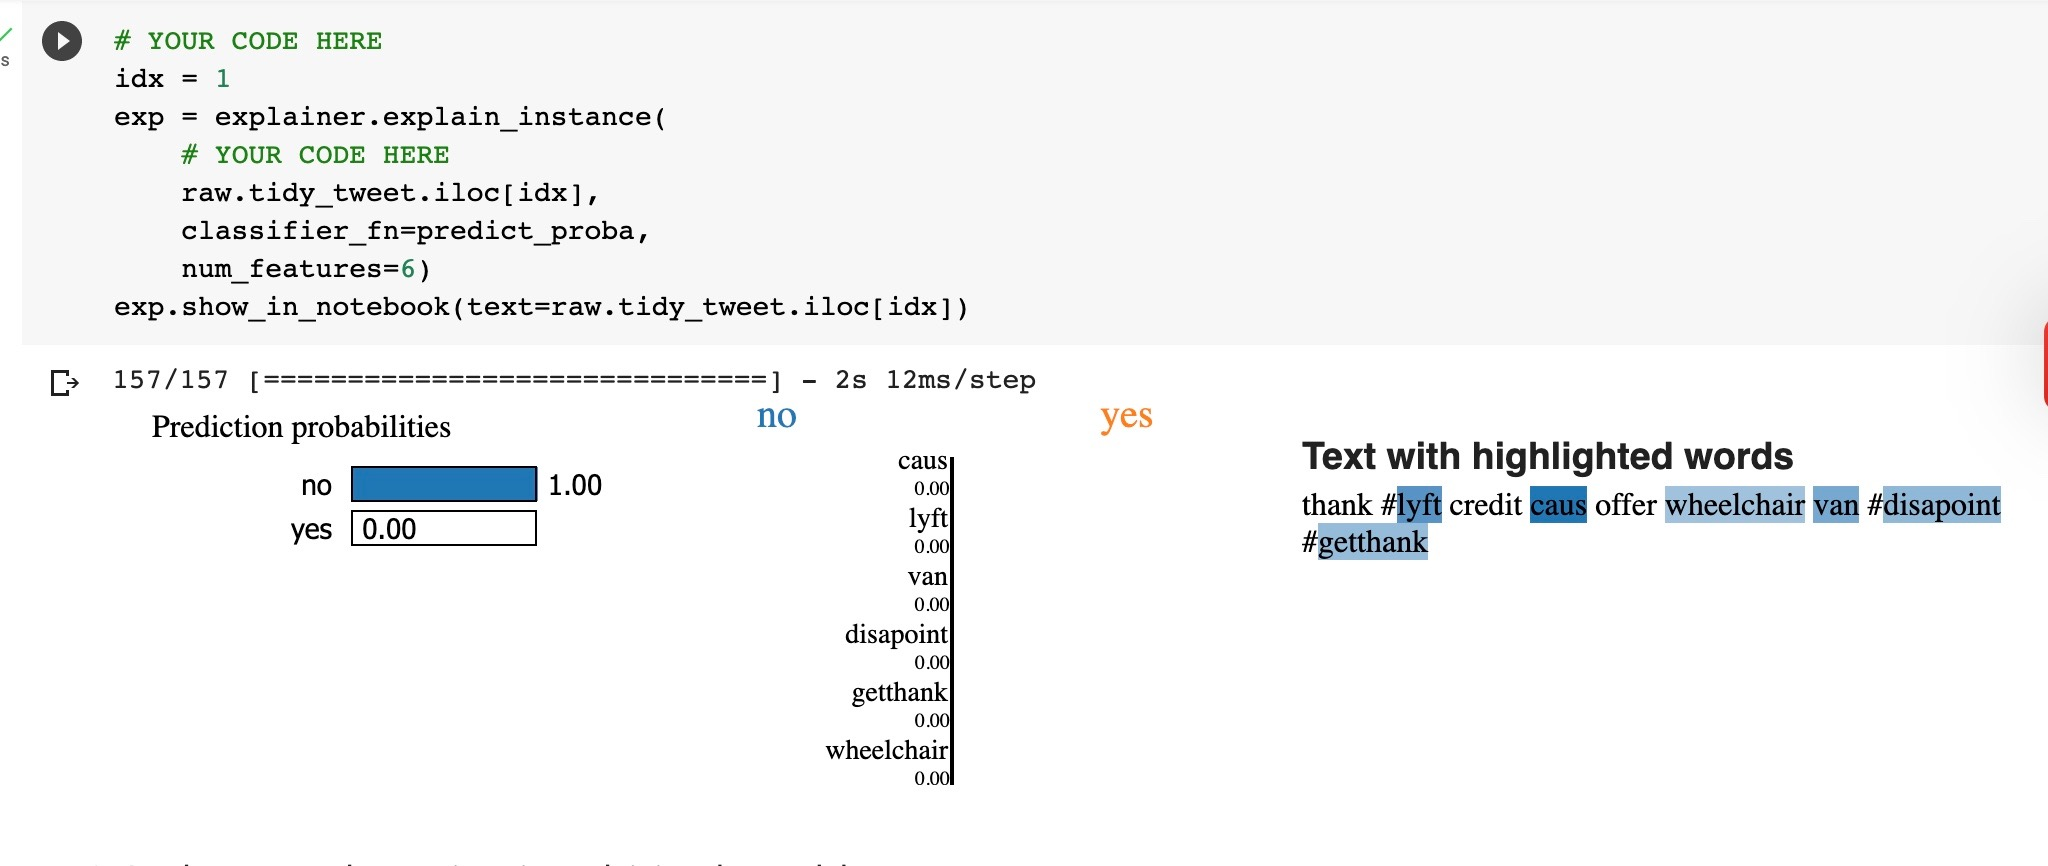

In [144]:
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '/content/drive/MyDrive/dog_dataset/lime.jpeg'
display(Image(filename=filename))

# Acknowledgement & Reference

- Data is adapted from [Twitter sentiment analysis](https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/#ProblemStatement)
- [Twitter sentiment analysis](https://github.com/prateekjoshi565/twitter_sentiment_analysis/blob/master/code_sentiment_analysis.ipynb) 
- [Introduction to Word Embedding and Word2Vec](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)
- [When to use GRU over LSTM?](https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm)
- Use a trained Word2Vec, Doc2Vec or FastTest embedding by `gensim` in buiding an embedding layers in Tensorflow, here's [how-to](https://github.com/RaRe-Technologies/gensim/wiki/Using-Gensim-Embeddings-with-Keras-and-Tensorflow).